# A simple example to start with...

This is a trivial case where a steam methane reforming unit supplies a constant H2 demand by importing natural gas. 

## Setup 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pyomo.environ as pyo
import Functions.f_multiResourceModels as fMultiResModels
import Functions.f_optimization as fOptimization 

nHours = 8760
t = np.arange(1,nHours + 1)

## Input data 

We define some basic parameters of the case, such as the node names (zones), the year and the conversion technologies used. 

In [2]:
zones=["PACA"] 
year=2013
ctechs=['OldNuke', 'SMR_class']

### Demand for resources
The demand for resources is given for each hour of the year in MW, in the format of a `DataFrame`. For fuels, the MW value corresponds to the lower heating value (LHV). The values for each resource are given in the form of an array with `nHours` elements, which could be for instance read from a CSV file.

In [3]:
df_resource_demand =  pd.DataFrame(data = { 
              'TIMESTAMP': t, # We add the TIMESTAMP so that it can be used as an index later. 
              'electricity': np.zeros(nHours),
              'hydrogen': 320 * np.ones(nHours) + 20 * np.sin(2 * np.pi * t / nHours), 
              'gas': np.zeros(nHours), 
              'uranium': np.zeros(nHours)
             } 
)
df_resource_demand

,TIMESTAMP,electricity,hydrogen,gas,uranium
0,1,0.0,320.014345,0.0,0.0
1,2,0.0,320.028690,0.0,0.0
2,3,0.0,320.043035,0.0,0.0
3,4,0.0,320.057381,0.0,0.0
4,5,0.0,320.071726,0.0,0.0
...,...,...,...,...,...
8755,8756,0.0,319.942619,0.0,0.0
8756,8757,0.0,319.956965,0.0,0.0
8757,8758,0.0,319.971310,0.0,0.0
8758,8759,0.0,319.985655,0.0,0.0


We can access the demand profiles like this: 

<AxesSubplot:xlabel='Time (h)', ylabel='Resource demand (MW)'>

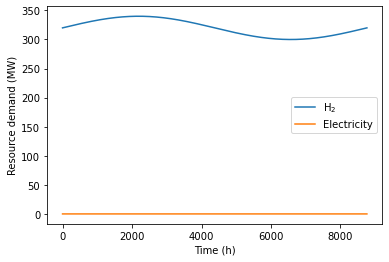

In [4]:
df_resource_demand.plot(x='TIMESTAMP', y=['hydrogen','electricity'], xlabel='Time (h)', 
                        ylabel='Resource demand (MW)', label=['H$_2$', 'Electricity'])

### Availability factors
The availability factors correspond to the share of a conversion technology capacity that is available during a given hour. In this case it is read from raw hourly data obtained elsewhere. 

In [5]:
availabilityFactor = pd.read_csv('Data/Input/availabilityFactor' + str(year) + '_' + str(zones[0]) + '_TIMExTECH.csv',
                                 sep=',', decimal='.', skiprows=0).set_index(["TIMESTAMP", "TECHNOLOGIES"])
itechs = availabilityFactor.index.isin(ctechs, level=1)
availabilityFactor = availabilityFactor.loc[(slice(None), itechs),:]

### Conversion technology parameters 
These are the techno-economic parameters of each conversion technology. The following parameters are given: 

| Parameter       | Unit          | Description |
| :-------------  | :-----------: | :-----------|
| `powerCost`     | EUR/MW        | Power-dependant component of the operating expenses (OPEX) |
| `capacityCost`  | EUR/MW        | Capital expenditure (CAPEX) on a capacity basis |
| `minCapacity`  | MW        | Minimal allowed capacity |
| `maxCapacity`  | MW        | Maximal allowed capacity |
| `RampConstraintPlus`  | % of capacity/h        | Maximal allowed positive ramp |
| `RampConstraintMoins`  | % of capacity/h        | Maximal allowed negative ramp |
| `EmissionCO2`  | tCO$_2$/MW      | Power-dependant greenhouse gas emissions (GHG) |
| `Conversion`  | MW      | Amount of resource produced or consumed (negative) for an operating power of 1 MW |

In [6]:
df_ctech_params = pd.DataFrame(data={'OldNuke': {
                            'powerCost': 0, 
                            'capacityCost': 245060, 
                            'minCapacity': 0.001, 
                            'maxCapacity': 0.001, 
                            'RampConstraintPlus': 0.04, # Ramp rates as percent of maximal capacity per hour
                            'RampConstraintMoins': 0.04, 
                            'EmissionCO2': 0,
                            'Conversion': {'electricity': 1, 'uranium':-3.03},
                            }, 
                'SMR_class': {
                            'powerCost': 0, 
                            'capacityCost': 62563, 
                            'minCapacity': 0, 
                            'maxCapacity': 1e6,
                            'EmissionCO2': 354,
                            'Conversion': {'hydrogen': 1, 'gas':-1.53},
                            }, 
               })
df_ctech_params

,OldNuke,SMR_class
powerCost,0,0
capacityCost,245060,62563
minCapacity,0.001,0
maxCapacity,0.001,1000000.0
RampConstraintPlus,0.04,NaN
RampConstraintMoins,0.04,NaN
EmissionCO2,0,354
Conversion,"{'electricity': 1, 'uranium': -3.03}","{'hydrogen': 1, 'gas': -1.53}"


### Discount and finance rate
Some general economic parameters.  

In [9]:
df_economic_params = pd.DataFrame({
    'discountRate':[0.04], 
    'financeRate': [0.04]
    }
)

###  Resource import price
These are the prices of imported resources, which should be given as in the form of an array with `nHours` elements, which could be for instance read from a CSV file. Values are given in EUR/MWh. 

In [10]:
df_resource_import_prices = pd.DataFrame(data={
    'TIMESTAMP': t, 
    'electricity': pd.read_csv('Data/Raw/electricity-grid-price-2013.csv', sep=',', decimal='.', index_col=0,header=None).values.flatten(), 
    'gas': 40 * np.ones(nHours),
    'uranium': 2.2 * np.ones(nHours),
    'hydrogen': 1e6 * np.ones(nHours),
})

### Storage parameters

These are the techno-economic parameters of each storage technology. The following parameters are given: 

| Parameter       | Unit          | Description |
| :-------------  | :-----------: | :-----------|
| `resource `     |               | The stored resource |
| `storagePowerCost` | EUR/MW        | Power-dependant component of the capital expenditure (CAPEX) |
| `storageEnergyCost`  | EUR/MWh       | Energy-dependant component of the capital expenditure (CAPEX) |
| `p_max`  | MW        | Maximal allowed power |
| `c_max`  | MWh       | Maximal allowed capacity |
| `dissipation`  | % of charge lost/h        | Maximal allowed positive ramp |



In [11]:
df_stech_params = pd.DataFrame(data={
                'Battery':  {
                            'resource': 'electricity', 
                            'storagePowerCost': 10753, 
                            'storageEnergyCost': 15658, 
                            'p_max': 5000, 
                            'c_max': 50000, 
                            'chargeFactors': {'electricity': 0.9200},
                            'dischargeFactors': {'electricity': 1.09},
                            'dissipation': 0.0085,
                            }, 
                'tankH2_G': {
                            'resource': 'hydrogen', 
                            'storagePowerCost': 1121, 
                            'storageEnergyCost': 604, 
                            'p_max': 0, 
                            'c_max': 0, 
                            'chargeFactors': {'electricity': 0.0168, 'hydrogen': 1.0},
                            'dischargeFactors': {'hydrogen': 1.0},
                            'dissipation': 0,
                            }, 
               })
    

df_stech_params 

,Battery,tankH2_G
resource,electricity,hydrogen
storagePowerCost,10753,1121
storageEnergyCost,15658,604
p_max,5000,0
c_max,50000,0
chargeFactors,{'electricity': 0.92},"{'electricity': 0.0168, 'hydrogen': 1.0}"
dischargeFactors,{'electricity': 1.09},{'hydrogen': 1.0}
dissipation,0.0085,0


### Grid connection parameters
These are parameters related to the French TURPE representing the grid connection costs. 

In [12]:
df_grid_cnx_params = pd.read_csv('Data\Raw\CalendrierHPHC_TIME.csv', sep=',', decimal='.', skiprows=0,
                                comment="#").set_index(["TIMESTAMP"])

## Running the model
We start by converting our dataframes to the formats required by the optimisation model. 

In [13]:
areaConsumption = df_resource_demand.melt(id_vars=['TIMESTAMP'], var_name='RESOURCES', value_name='areaConsumption').set_index(['TIMESTAMP', 'RESOURCES'])

TechParameters = df_ctech_params.transpose().fillna(0)
TechParameters.index.name='TECHNOLOGIES'
TechParametersList = ['powerCost','capacityCost','EnergyNbhourCap','minCapacity','maxCapacity','RampConstraintPlus','RampConstraintMoins','RampConstraintPlus2','RampConstraintMoins2','EmissionCO2']
for k in TechParametersList:
    if k not in TechParameters:
        TechParameters[k] = 0 
TechParameters.drop(columns='Conversion', inplace=True)
TechParameters

conversionFactor = pd.DataFrame(data={tech: df_ctech_params.loc['Conversion',tech] for tech in df_ctech_params.columns}).fillna(0)
conversionFactor.index.name='RESOURCES'
conversionFactor = conversionFactor.reset_index('RESOURCES').melt(id_vars=['RESOURCES'], var_name='TECHNOLOGIES',value_name='conversionFactor').set_index(['RESOURCES', 'TECHNOLOGIES'])

ImportPrices = df_resource_import_prices.melt(id_vars=['TIMESTAMP'], var_name='RESOURCES', value_name='importCost').set_index(['TIMESTAMP', 'RESOURCES'])

Economics = df_economic_params.melt(var_name='Eco').set_index('Eco')


StorageParameters = df_stech_params.transpose().fillna(0)
StorageParameters.index.name='STOCK_TECHNO'
StorageParametersList = ['resource', 'storagePowerCost', 'storageEnergyCost', 'p_max', 'c_max']
for k in StorageParametersList:
    if k not in StorageParameters:
        StorageParameters[k] = 0 
StorageParameters.drop(columns=['chargeFactors', 'dischargeFactors', 'dissipation'], inplace=True)
StorageParameters

df = {}
for k1, k2 in (('charge', 'In'),  ('discharge', 'Out')): 
    df[k1] = pd.DataFrame(data={tech: df_stech_params.loc[k1 + 'Factors',tech] for tech in df_stech_params.columns}).fillna(0)
    df[k1].index.name='RESOURCES'
    df[k1] = df[k1].reset_index(['RESOURCES']).melt(id_vars=['RESOURCES'], var_name='TECHNOLOGIES',value_name='storageFactor' + k2)

df['dissipation'] = pd.concat(pd.DataFrame(
                                  data={'dissipation': [df_stech_params.loc['dissipation',tech]], 
                                        'RESOURCES': df_stech_params.loc['resource',tech], 
                                        'TECHNOLOGIES': tech}) for tech in df_stech_params.columns
                             )

storageFactors = pd.merge(df['charge'], df['discharge'], how='outer').fillna(0)
storageFactors = pd.merge(storageFactors, df['dissipation'], how='outer').fillna(0).set_index(['RESOURCES', 'TECHNOLOGIES'])

Calendrier = df_grid_cnx_params

We run the model (this may take sometime)...

In [14]:
model = fMultiResModels.GetElectricSystemModel_MultiResources_SingleNode(areaConsumption, availabilityFactor, TechParameters, ImportPrices,conversionFactor)
opt = pyo.SolverFactory('glpk', executable=r'C:\Users\p.affonso_nobrega\Anaconda3\pkgs\glpk-5.0-h8ffe710_0\Library\bin\glpsol.exe')
results = opt.solve(model)
# result analysis

And we retrieve the result variables in `DataFrame` format.

| Parameter       | Unit          | Description |
| :-------------  | :-----------: | :-----------|
| `power_Dvar`     | MW      | Power of each conversion technology at each time step.|
| `powerCosts_Pvar`     | EUR    | Sum of power-dependant costs for each conversion technology.|
| `capacityCosts_Pvar`     | EUR    | Sum of capacity-dependant costs for each conversion technology.|
| `capacity_Dvar`     | EUR    | Capacity for each conversion technology.|
| `importation_Dvar`  | MW        | Amount of each resource imported at each time step. |
| `importCosts_Pvar`  | EUR        | Sum of import costs for each resource. |
| `energy_Pvar`  | MW        | Produced power for each resource at each time step. |
| `carbon_Pvar`  | tCO$_2$/h      | Greenhouse gas emissions (GHG) at each time step.|

In [15]:
outputData = fOptimization.getVariables_panda_indexed(model)
for v in outputData.values():
    display(v)

,TIMESTAMP,TECHNOLOGIES,power_Dvar
0,1,OldNuke,0.000000
1,1,SMR_class,320.014345
2,2,OldNuke,0.000000
3,2,SMR_class,320.028690
4,3,OldNuke,0.000000
...,...,...,...
17515,8758,SMR_class,319.971310
17516,8759,OldNuke,0.000000
17517,8759,SMR_class,319.985655
17518,8760,OldNuke,0.000000


,TECHNOLOGIES,powerCosts_Pvar
0,OldNuke,0.0
1,SMR_class,0.0


,TECHNOLOGIES,capacity_Dvar
0,OldNuke,0.001
1,SMR_class,340.000


,TECHNOLOGIES,capacityCosts_Pvar
0,OldNuke,245.06
1,SMR_class,21271420.00


,TIMESTAMP,RESOURCES,importation_Dvar
0,1,hydrogen,0.000000
1,1,electricity,0.000000
2,1,uranium,0.000000
3,1,gas,489.621948
4,2,hydrogen,0.000000
...,...,...,...
35035,8759,gas,489.578052
35036,8760,hydrogen,0.000000
35037,8760,electricity,0.000000
35038,8760,uranium,0.000000


,RESOURCES,importCosts_Pvar
0,hydrogen,-0.0
1,electricity,-0.0
2,uranium,-0.0
3,gas,171555840.0


,TIMESTAMP,RESOURCES,energy_Pvar
0,1,hydrogen,320.014345
1,1,electricity,-0.000000
2,1,uranium,0.000000
3,1,gas,0.000000
4,2,hydrogen,320.028690
...,...,...,...
35035,8759,gas,0.000000
35036,8760,hydrogen,320.000000
35037,8760,electricity,-0.000000
35038,8760,uranium,0.000000


,TIMESTAMP,carbon_Pvar
0,1,113285.078190
1,2,113290.156378
2,3,113295.234561
3,4,113300.312736
4,5,113305.390900
...,...,...
8755,8756,113259.687264
8756,8757,113264.765439
8757,8758,113269.843622
8758,8759,113274.921810


We can use queries as below to retrieve different series. 

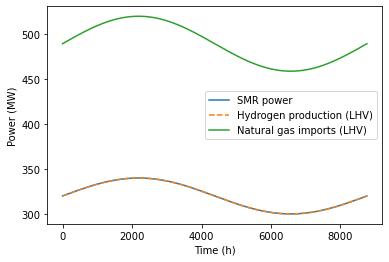

In [16]:
outputData['power_Dvar'].query('TECHNOLOGIES == "SMR_class"').set_index('TIMESTAMP')['power_Dvar'].plot(label='SMR power')
outputData['energy_Pvar'].query('RESOURCES == "hydrogen"').set_index('TIMESTAMP')['energy_Pvar'].plot(linestyle='--',label='Hydrogen production (LHV)') 
outputData['importation_Dvar'].query('RESOURCES == "gas"').set_index('TIMESTAMP')['importation_Dvar'].plot(linestyle='-',label='Natural gas imports (LHV)') 
plt.xlabel('Time (h)')
plt.ylabel('Power (MW)')
plt.legend(loc=0)